In [1]:
import torch
import torch.nn as nn

# Import the gym module
import gym
import numpy as np
import time 

In [2]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

In [3]:
def preprocess(img):
    # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
    img = np.mean(img, axis=2).astype(np.uint8) # to gray, uint8 for low memory
    img = img[::2, ::2][17:97] # downsample(1/2) & to square
    img = np.expand_dims(img, 0) # (1, 80, 80)
    return img

In [4]:
s = env.reset()
done = False
while not done:
    a = env.action_space.sample()
    s2, _, done, _ = env.step(a)

In [5]:
from matplotlib import pyplot as plt
plt.imshow(s2)

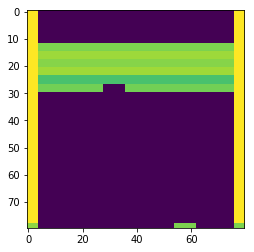

In [6]:
plt.imshow(preprocess(s2)[0])

In [7]:
from collections import deque
import random 

class ReplayMemory(object):
    def __init__(self, capacity):
        self.deque = deque(maxlen=capacity)
    
    def append(self, state, action, reward, next_state, done):
        self.deque.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        return random.sample(self.deque, batch_size)
    
    def __len__(self):
        return len(self.deque)

In [8]:
class FrameSkipper(object):
    # consecutive frame을 4개씩 병합하여 새로운 x를 하나씩 만드는 클래스
    # 만들어진 x는 4개씩 concat하고 s를 만들어서 DQN의 input으로 들어감
    def __init__(self, k_skip=4):
        self.state_deque = deque(maxlen=k_skip) # [x1, x2, x3, x4]
        self.frame_ls = []
        self.k_skip = k_skip
        
        # 최초에는 초기 화면(env.reset)으로 채워둠
        self.env = gym.make('BreakoutDeterministic-v4')
        padding_state = preprocess(self.env.reset())
        for _ in range(k_skip):
            self.state_deque.append(padding_state)
    
    def preprocess(self, img):
        # 저장할 때는 전처리를 거친 후 np.array 형태로 저장
        img = np.mean(img, axis=2).astype(np.uint8) # to gray, uint8 for low memory
        img = img[::2, ::2][17:97] # downsample(1/2) & to square
        img = np.expand_dims(img, 0) # (1, 80, 80)
        return img
    
    def append_frame(self, s):
        self.frame_ls.append(self.preprocess(s))
        # 4개의 프레임을 skip한 후에는, 4개를 합쳐서(element-wise maximum) x를 만들고 저장
        if len(self) == self.k_skip:
            x = self.aggregate_frame()
            self.state_deque.append(x)
            self.frame_ls = []  # frame을 다시 처음부터 저장
    
    def aggregate_frame(self):
        # element-wise maximum to aggregate
        return np.maximum.reduce(self.frame_ls)
    
            
    def get_state(self):
        S = np.array([self.state_deque[i] for i in range(self.k_skip)]) # S = [x1, x2, x3, x4], (4, 1, 80, 80)
        S = np.swapaxes(S, 0, 1) # (1, 4, 80, 80)
        return S
    
    def __len__(self):
        return len(self.frame_ls)

In [9]:
class DDQN(nn.Module):
    # Dueling DQN
    def __init__(self, in_dim, n_action):
        super(DDQN, self).__init__()
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        
        self.conv = nn.Sequential(
            nn.Conv2d(in_dim, 32, (8, 8), stride=4), nn.ReLU(), # conv 1
            nn.Conv2d(32, 64, (4, 4), stride=2), nn.ReLU(), # conv 2
            nn.Conv2d(64, 64, (3, 3), stride=1), nn.ReLU() # conv 3
        )
        # V(s) : value-stream
        self.value_stream = nn.Sequential(
            nn.Linear(64*6*6, 512), nn.ReLU(), # hidden layer
            nn.Linear(512, 1)
        )
        
        # A(s,a) : action-stream
        self.action_stream = nn.Sequential(
            nn.Linear(64*6*6, 512), nn.ReLU(),
            nn.Linear(512, n_action)
        )
        
    def to_tensor(self, img):
        img = torch.tensor(img, dtype=torch.float32, device=self.device).cuda(non_blocking=True) # to tensor
        img /= 255                                   # normalize into 0-1
        while img.dim() < 4 :                        # 4-dim
            img = img.unsqueeze(0)
        return img
        
    def forward(self, frames):
        frames = self.to_tensor(frames) 
        conved = self.conv(frames)
        conved = conved.view(conved.size(0), -1)
        
        # key of Dueling DQN : Q(s,a_i) = V(S) + A(s,a_i) - mean(A)
        value = self.value_stream(conved) # V(s), dim=(batch_size, 1)
        action = self.action_stream(conved) # A(s,a), dim=(batch_size, n_action)
        
        output = value + (action - torch.mean(action, dim=1, keepdim=True)) # V(s) + (A(s,a_i) - mean(A)), dim=(batch_size, n_action)
        return output

In [10]:
behavior_net = DDQN(in_dim=4, n_action=4)
target_net = DDQN(in_dim=4, n_action=4)

behavior_net.to(behavior_net.device) # model to cuda
target_net.to(target_net.device)     # model to cuda

DDQN(
  (conv): Sequential(
    (0): Conv2d(4, 32, kernel_size=(8, 8), stride=(4, 4))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2))
    (3): ReLU()
    (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (5): ReLU()
  )
  (value_stream): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=1, bias=True)
  )
  (action_stream): Sequential(
    (0): Linear(in_features=2304, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [11]:
def epsilon_decay(n_total_frame):
    return np.max([1 - 9.0*1e-07*n_total_frame, 0.1])    

In [12]:
def grow_batch_size(current_memory, max_memory):
    # grow batch size from 32 to 128 as respect to memory size
    memory_ratio = current_memory / max_memory
    new_batch_size = int(32 + 96*memory_ratio)
    return new_batch_size

In [25]:
class Fitter():
    def __init__(self, env, behavior_net, target_net, train_method='DQN'):
        self.env = env
        self.train_method = train_method
        
        # networks
        self.behavior_net = behavior_net
        self.target_net = target_net
        self.behavior_net.to(self.behavior_net.device) # model to cuda
        self.target_net.to(self.target_net.device)     # model to cuda
        
        # train parameters
        self.gamma = 0.99 #as written in paper
        self.criterion = nn.SmoothL1Loss() # huber loss (error-clipping)
        self.optim = torch.optim.RMSprop(self.behavior_net.parameters(), lr=0.00025) #as written in paper
        
        # train details
        self.total_frame = 0
        self.total_episode = 0
        self.batch_size = 32
        self.memory_size = 1000000 # as written in paper
        self.min_replay = 50000 # as written in the paper
        self.replay_memory = ReplayMemory(self.memory_size)
        self.reward_ls = []
    
    def train(self, max_total_frame):
        while self.total_frame < max_total_frame :
            self.total_episode += 1
            
            frame_skipper = FrameSkipper(k_skip=4) #과거 k개의 frame을 하나의 state로 합쳐주는 클래스
            s = env.reset()  # small s represents each frame
            n_step = 0       # each episode의 step의 횟수 
            
            # re-calculate batch_size
            e = epsilon_decay(self.total_frame)
            batch_size = grow_batch_size(len(self.replay_memory), self.memory_size)
                    
            done = False
            while not done:
                self.total_frame += 1
                n_step += 1
                
                # update target_net every 10,000 steps
                if n_step%10000 == 0 :
                    self.update_target()
                
                # start of every 4 consecutive frames, choose action!                
                if n_step%4 == 1:
                    # S = [x1, x2, x3, x4] for neural-network input
                    # x represents feature(element-wise max) from every 4 consecutive frames(4*s)
                    S = frame_skipper.get_state()
                    self.S = S
                    r_sum = 0    # sum of reward for the following 4 frames
                    
                    # if it is the first frame of the game, Do Something!
                    if n_step == 1:
                        a = random.choice([1,2,3])
                    
                    # else, Choose an action by e-greedy
                    else:
                        if np.random.rand(1) < e :
                            a = env.action_space.sample()
                        else:
                            q_pred = self.behavior_net(S)
                            a = torch.argmax(q_pred).item()
                
                # repeat the same action 4 times
                s_next, r, done, _, = env.step(a)
                frame_skipper.append_frame(s_next)
                r_sum += r

                # end of every 4 consecutive frames
                # genenrate new x, and update S
                if n_step%4 == 0 :
                    S_new = frame_skipper.get_state()
                    self.replay_memory.append(S, a, r_sum, S_new, done)
                
                # no training when not enough replay
                if len(self.replay_memory) < self.min_replay:
                    continue
                else:
                    # train
                    mini_batch = self.replay_memory.sample(batch_size)
                    self.train_batch(mini_batch)                
                # single-episode(game) is now done
            
            
            # no updating target, no testing when not enough replay
            if len(self.replay_memory) < self.min_replay:
                continue

            # update target, do test for every 10 episodes(games)
            if self.total_episode%10 == 0:
                print('total_frame: %s'%self.total_frame)
                reward = fitter.test()
                self.reward_ls.append(reward)  
                
                
    def train_batch(self, mini_batch):
        batch_size = len(mini_batch)
        S = np.array([tup[0] for tup in mini_batch]).squeeze(1) # State
        A = np.array([tup[1] for tup in mini_batch]) # actions
        R = np.array([tup[2] for tup in mini_batch]) # rewards
        S_next = np.array([tup[3] for tup in mini_batch]).squeeze(1) # next_State
        D = np.array([tup[4] for tup in mini_batch]) # dones
        
        q_targets = self.target_net(S) # Q-values of current state with targetDDQN
        q_targets_next = self.target_net(S_next) # Q-values of next state from targetDDQN
        
        if self.train_method=='DQN':
            for i in range(batch_size):
                a, r, done = A[i], R[i], D[i]
                if done:
                    q_targets[i, a] = r
                else:
                    q_targets[i, a] = r + self.gamma*torch.max(q_targets_next[i])
        
        elif self.train_method=='DoubleDQN':
            next_behavior_net_actions = torch.argmax(self.behavior_net(S_next), dim=1) # choose argmax actions from behaviorDDQN in S_next
                    
            for i in range(batch_size):
                a, r, done = A[i], R[i], D[i]
                next_behavior_net_action = next_behavior_net_actions[i].item() # choose argmax actions from behaviorDDQN in S_next
                if done:
                    q_targets[i, a] = r
                else:
                    q_targets[i, a] = r + self.gamma*q_targets_next[i, next_behavior_net_action]
            
        # 예측치(pred)와 목표치(true)
        q_behaviors = self.behavior_net(S)
        
        self.optim.zero_grad()
        loss = self.criterion(q_targets, q_behaviors)
        loss.backward()
        self.optim.step()
        return

    
    def update_target(self):
        self.target_net.load_state_dict(self.behavior_net.state_dict())
        return 
    
    
    def test(self):
        frame_skipper = FrameSkipper()
        initial_state = self.env.reset()  # save initial state for comparison
        s = self.env.reset()
        e = 0.05 # e-greedy, 
        
        n_step = 0
        r_sum = 0
        done=False
        while not done:
            # 초기 화면에서는 1,2,3 중 임의의 액션을 실행
            # 게임이 시작된 후, 공을 놓치면, life가 깍이고 다시 초기화면으로 돌아옴 
            if np.array_equal(s, initial_state):
                a = random.choice([1, 2, 3])
            else:
                # e-greedy search, e=0.05
                if np.random.rand(1) < e:
                    a = self.env.action_space.sample()
                else:
                    S = frame_skipper.get_state()
                    a = torch.argmax(self.behavior_net(S)).item()
            
            s, r, done, _ = self.env.step(a)
            frame_skipper.append_frame(s)
            r_sum += r
            n_step += 1
            
        print('Total Step: %s \t Total Score: %s'%(n_step, r_sum))
        return r_sum

In [28]:
fitter = Fitter(env, behavior_net, target_net, train_method='DoubleDQN')

In [23]:
# Create a breakout environment
env = gym.make('BreakoutDeterministic-v4')

In [ ]:
max_frame = 10000000
fitter.train(max_frame)

total_frame: 25443
Total Step: 351 	 Total Score: 0.0
total_frame: 27873
Total Step: 301 	 Total Score: 1.0
total_frame: 30289
Total Step: 470 	 Total Score: 0.0
total_frame: 32680
Total Step: 540 	 Total Score: 0.0
total_frame: 35022
Total Step: 331 	 Total Score: 0.0
total_frame: 37604
Total Step: 457 	 Total Score: 0.0
total_frame: 40185
Total Step: 1278 	 Total Score: 0.0
total_frame: 42758
Total Step: 294 	 Total Score: 0.0
total_frame: 45055
Total Step: 299 	 Total Score: 0.0


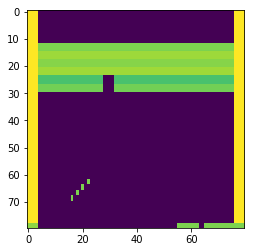

In [21]:
# how skip-frame works
plt.imshow(fitter.S[0][0])

In [22]:
fitter.replay_memory = replay

In [1]:
class SumTree(object):
    """
    This SumTree code is modified version of Morvan Zhou: 
    https://github.com/MorvanZhou/Reinforcement-learning-with-tensorflow/blob/master/contents/5.2_Prioritized_Replay_DQN/RL_brain.py
    https://medium.freecodecamp.org/improvements-in-deep-q-learning-dueling-double-dqn-prioritized-experience-replay-and-fixed-58b130cc5682
    """
    data_pointer = 0
    
    """
    Here we initialize the tree with all nodes = 0, and initialize the data with all values = 0
    """
    def __init__(self, capacity):
        self.capacity = capacity # Number of leaf nodes (final nodes) that contains experiences
        
        # Generate the tree with all nodes values = 0
        # To understand this calculation (2 * capacity - 1) look at the schema above
        # Remember we are in a binary node (each node has max 2 children) so 2x size of leaf (capacity) - 1 (root node)
        # Parent nodes = capacity - 1
        # Leaf nodes = capacity
        self.tree = np.zeros(2 * capacity - 1)
        
        """ tree:
            0
           / \
          0   0
         / \ / \
        0  0 0  0  [Size: capacity] it's at this line that there is the priorities score (aka pi)
        """
        
        # Contains the experiences (so the size of data is capacity)
        self.data = np.zeros(capacity, dtype=object)
    
    
    """
    Here we add our priority score in the sumtree leaf and add the experience in data
    """
    def add(self, priority, data):
        # Look at what index we want to put the experience
        tree_index = self.data_pointer + self.capacity - 1
        
        """ tree:
            0
           / \
          0   0
         / \ / \
tree_index  0 0  0  We fill the leaves from left to right
        """
        
        # Update data frame
        self.data[self.data_pointer] = data
        
        # Update the leaf
        self.update(tree_index, priority)
        
        # Add 1 to data_pointer
        self.data_pointer += 1
        
        if self.data_pointer >= self.capacity:  # If we're above the capacity, you go back to first index (we overwrite)
            self.data_pointer = 0
            
    
    """
    Update the leaf priority score and propagate the change through tree
    """
    def update(self, tree_index, priority):
        # Change = new priority score - former priority score
        change = priority - self.tree[tree_index]
        self.tree[tree_index] = priority
        
        # then propagate the change through tree
        while tree_index != 0:    # this method is faster than the recursive loop in the reference code
            
            """ 
            Here we want to access the line above
            THE NUMBERS IN THIS TREE ARE THE INDEXES NOT THE PRIORITY VALUES
            
                0
               / \
              1   2
             / \ / \
            3  4 5  [6] 
            
            If we are in leaf at index 6, we updated the priority score
            We need then to update index 2 node
            So tree_index = (tree_index - 1) // 2
            tree_index = (6-1)//2
            tree_index = 2 (because // round the result)
            """
            tree_index = (tree_index - 1) // 2
            self.tree[tree_index] += change
    
    
    """
    Here we get the leaf_index, priority value of that leaf and experience associated with that index
    """
    def get_leaf(self, v):
        """
        Tree structure and array storage:
        Tree index:
             0         -> storing priority sum
            / \
          1     2
         / \   / \
        3   4 5   6    -> storing priority for experiences
        Array type for storing:
        [0,1,2,3,4,5,6]
        """
        parent_index = 0
        
        while True: # the while loop is faster than the method in the reference code
            left_child_index = 2 * parent_index + 1
            right_child_index = left_child_index + 1
            
            # If we reach bottom, end the search
            if left_child_index >= len(self.tree):
                leaf_index = parent_index
                break
            
            else: # downward search, always search for a higher priority node  
                if v <= self.tree[left_child_index]:
                    parent_index = left_child_index
                else:
                    v -= self.tree[left_child_index]
                    parent_index = right_child_index
            
        data_index = leaf_index - self.capacity + 1
        return leaf_index, self.tree[leaf_index], self.data[data_index]
    
    @property
    def total_priority(self):
        return self.tree[0] # Returns the root node

In [3]:
import numpy as np

In [50]:
tree = SumTree(4)

In [51]:
tree.tree

array([0., 0., 0., 0., 0., 0., 0.])

In [52]:
tree.data

array([0, 0, 0, 0], dtype=object)

In [53]:
tree.add(0.1, 1)
tree.add(0.2, 2)
tree.add(0.3, 3)
tree.add(0.4, 4)

In [54]:
tree.tree

array([1. , 0.3, 0.7, 0.1, 0.2, 0.3, 0.4])

In [55]:
tree.data

array([1, 2, 3, 4], dtype=object)

In [62]:
tree.get_leaf(0.11)

(4, 0.2, 2)

In [65]:
tree.capacity

4

In [67]:
tree.tree

array([1. , 0.3, 0.7, 0.1, 0.2, 0.3, 0.4])

In [71]:
max_priority = max(tree.tree[-tree.capacity:])

In [72]:
max_priority

0.4

In [ ]:
class Memory(object):  # stored as ( s, a, r, s_, done ) in SumTree
    """
    This SumTree code is modified version and the original code is from:
    https://github.com/jaara/AI-blog/blob/master/Seaquest-DDQN-PER.py
    """
    PER_e = 0.01  # Hyperparameter that we use to avoid some experiences to have 0 probability of being taken
    PER_a = 0.6  # Hyperparameter that we use to make a tradeoff between taking only exp with high priority and sampling randomly
    PER_b = 0.4  # importance-sampling, from initial value increasing to 1
    
    PER_b_increment_per_sampling = 0.001
    
    absolute_error_upper = 1.  # clipped abs error

    def __init__(self, capacity):
        # Making the tree 
        """
        Remember that our tree is composed of a sum tree that contains the priority scores at his leaf
        And also a data array
        We don't use deque because it means that at each timestep our experiences change index by one.
        We prefer to use a simple array and to overwrite when the memory is full.
        """
        self.tree = SumTree(capacity)
        
    """
    Store a new experience in our tree
    Each new experience have a score of max_prority (it will be then improved when we use this exp to train our DDQN)
    """
    def store(self, experience):
        # Find the max priority
        max_priority = np.max(self.tree.tree[-self.tree.capacity:])
        
        # If the max priority = 0 we can't put priority = 0 since this exp will never have a chance to be selected
        # So we use a minimum priority
        if max_priority == 0:
            max_priority = self.absolute_error_upper
        
        self.tree.add(max_priority, experience)   # set the max p for new p

        
    """
    - First, to sample a minibatch of k size, the range [0, priority_total] is / into k ranges.
    - Then a value is uniformly sampled from each range
    - We search in the sumtree, the experience where priority score correspond to sample values are retrieved from.
    - Then, we calculate IS weights for each minibatch element
    """
    def sample(self, n):
        # Create a sample array that will contains the minibatch
        memory_b = []
        
        b_idx, b_ISWeights = np.empty((n,), dtype=np.int32), np.empty((n, 1), dtype=np.float32)
        
        # Calculate the priority segment
        # Here, as explained in the paper, we divide the Range[0, ptotal] into n ranges
        priority_segment = self.tree.total_priority / n       # priority segment
    
        # Here we increasing the PER_b each time we sample a new minibatch
        self.PER_b = np.min([1., self.PER_b + self.PER_b_increment_per_sampling])  # max = 1
        
        # Calculating the max_weight
        p_min = np.min(self.tree.tree[-self.tree.capacity:]) / self.tree.total_priority
        max_weight = (p_min * n) ** (-self.PER_b)
        
        for i in range(n):
            """
            A value is uniformly sample from each range
            """
            a, b = priority_segment * i, priority_segment * (i + 1)
            value = np.random.uniform(a, b)
            
            """
            Experience that correspond to each value is retrieved
            """
            index, priority, data = self.tree.get_leaf(value)
            
            #P(j)
            sampling_probabilities = priority / self.tree.total_priority
            
            #  IS = (1/N * 1/P(i))**b /max wi == (N*P(i))**-b  /max wi
            b_ISWeights[i, 0] = np.power(n * sampling_probabilities, -self.PER_b)/ max_weight
                                   
            b_idx[i]= index
            
            experience = [data]
            
            memory_b.append(experience)
        
        return b_idx, memory_b, b_ISWeights
    
    """
    Update the priorities on the tree
    """
    def batch_update(self, tree_idx, abs_errors):
        abs_errors += self.PER_e  # convert to abs and avoid 0
        clipped_errors = np.minimum(abs_errors, self.absolute_error_upper)
        ps = np.power(clipped_errors, self.PER_a)

        for ti, p in zip(tree_idx, ps):
            self.tree.update(ti, p)
"""
This function will do the part
With ϵ select a random action atat, otherwise select at=argmaxaQ(st,a)
"""
def predict_action(explore_start, explore_stop, decay_rate, decay_step, state, actions):
    ## EPSILON GREEDY STRATEGY
    # Choose action a from state s using epsilon greedy.
    ## First we randomize a number
    exp_exp_tradeoff = np.random.rand()

    # Here we'll use an improved version of our epsilon greedy strategy used in Q-learning notebook
    explore_probability = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * decay_step)
    
    if (explore_probability > exp_exp_tradeoff):
        # Make a random action (exploration)
        action = random.choice(possible_actions)
        
    else:
        # Get action from Q-network (exploitation)
        # Estimate the Qs values state
        Qs = sess.run(DQNetwork.output, feed_dict = {DQNetwork.inputs_: state.reshape((1, *state.shape))})
        
        # Take the biggest Q value (= the best action)
        choice = np.argmax(Qs)
        action = possible_actions[int(choice)]
                
    return action, explore_probability
In [ ]:
# This function helps us to copy one set of variables to another
# In our case we use it when we want to copy the parameters of DQN to Target_network
# Thanks of the very good implementation of Arthur Juliani https://github.com/awjuliani
def update_target_graph():
    
    # Get the parameters of our DQNNetwork
    from_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "DQNetwork")
    
    # Get the parameters of our Target_network
    to_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, "TargetNetwork")

    op_holder = []
    
    # Update our target_network parameters with DQNNetwork parameters
    for from_var,to_var in zip(from_vars,to_vars):
        op_holder.append(to_var.assign(from_var))
    return op_holder
